## Imports

In [ ]:
from torch.utils import data
import h5py
from matplotlib import pyplot as plt
from prdepthPytorch.UNetPytorch import *
from prdepthPytorch.utils import *
import numpy as np

In [4]:
PSZ = 32
stride = 4
H,W = [192,256]
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
midas.eval()
transform = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform
H_patches = int((H-PSZ)/stride + 1)
W_patches = int((W-PSZ)/stride + 1)

outsize = [H_patches,W_patches]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Using cache found in C:\Users\Aneel/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\Aneel/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\Aneel/.cache\torch\hub\intel-isl_MiDaS_master


In [5]:
from pathlib import Path
p = Path('data/train/official')
files = sorted(p.glob('*.h5'))
train_images = []
train_features = []
train_depths = []
iter = 0
for h5dataset_fp in files:
    f = h5py.File(h5dataset_fp)
    image = torch.tensor(f["rgb"]).permute(1,2,0)
    depth = torch.tensor(f["depth"]).unsqueeze(0).permute(1,2,0)

    ## Downsample image and depth to size of midas inputs (192 X 256), and create overlapping patches as well
    DSimage = transform(image.numpy())
    DSdepth = transform(depth.repeat(1,1,3).numpy())[:,0,...].unsqueeze(1)
    img_patches = nn.Unfold(PSZ, stride=stride)(DSimage).view(3, PSZ, PSZ, H_patches, W_patches) #maybe add 1 to front of view for batches?
    depth_patches = nn.Unfold(PSZ, stride=stride)(DSdepth).view(1, PSZ, PSZ, H_patches, W_patches)

    ## Get feature mapping from midas
    features = get_midas_features(DSimage, midas)

    train_images.append(img_patches)
    train_features.append(features)
    train_depths.append(depth_patches)
    iter = iter +1
    if iter % 50 == 0:
        print(iter)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [7]:
p = Path('data/val/official')
files = sorted(p.glob('*.h5'))
val_images = []
val_features = []
val_depths = []
for h5dataset_fp in files:
    f = h5py.File(h5dataset_fp)
    image = torch.tensor(f["rgb"]).permute(1,2,0)
    depth = torch.tensor(f["depth"]).unsqueeze(0).permute(1,2,0)

    ## Downsample image and depth to size of midas inputs (192 X 256), and create overlapping patches as well
    DSimage = transform(image.numpy())
    DSdepth = transform(depth.repeat(1,1,3).numpy())[:,0,...].unsqueeze(1)
    img_patches = nn.Unfold(PSZ, stride=stride)(DSimage).view(3, PSZ, PSZ, H_patches, W_patches) #maybe add 1 to front of view for batches?
    depth_patches = nn.Unfold(PSZ, stride=stride)(DSdepth).view(1, PSZ, PSZ, H_patches, W_patches)

    ## Get feature mapping from midas
    features = get_midas_features(DSimage, midas)

    val_images.append(img_patches)
    val_features.append(features)
    val_depths.append(depth_patches)
    iter = iter +1


In [9]:
#Intialize dataset
class NYUv2Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, features, depths):
        self.imgs = imgs
        self.depths = depths
        self.features = features

    def __len__(self):
        return len(self.imgs)
    # Each img can have more than one bbox
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        img = self.imgs[index]
        depth = self.depths[index]
        feature = self.features[index]
        sample = {'image': img, 'features': feature, 'depth': depth}
        return sample

In [10]:
batch_size = 1
traindataset = NYUv2Dataset(imgs = train_images, features = train_features , depths = train_depths)
train_loader = torch.utils.data.DataLoader(
                 dataset=traindataset,
                 batch_size=batch_size,
                 shuffle=False)

valdataset = NYUv2Dataset(imgs = val_images, features = val_features , depths = val_depths)
test_loader = torch.utils.data.DataLoader(
                dataset=valdataset,
                batch_size=1,
                shuffle=False)

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Initialize models
priormodel = Prior_net(outsize).to(device)
posteriormodel = Posterior_net(outsize).to(device)
VAE = VAEModel(outsize).to(device)

lr = 2e-4
#Intialize training setup / loss (using 3 different networks for now ?
VAEoptimizer = torch.optim.Adam(VAE.parameters(), lr=lr, weight_decay=0)
prioroptim = torch.optim.Adam(priormodel.parameters(), lr=lr, weight_decay=0)
postoptim = torch.optim.Adam(posteriormodel.parameters(), lr=lr, weight_decay=0)
def center_depth(gt_depth):
    max_d = torch.max(gt_depth)
    min_d = torch.min(gt_depth)
    range_d = max_d-min_d
    gt2 = (gt_depth-(max_d-range_d/2))/(range_d/2)
    return gt2

In [12]:
epochs = 5
all_loss = []
all_kl = []
all_l1 = []
L1loss = torch.nn.L1Loss()
for epoch in range(epochs):
    epoch_loss = []
    kl_list = []
    l1_list = []
    for step,data in enumerate(train_loader):
        features = data['features'].squeeze(0)
        depth_patches = data['depth'].squeeze(0)
        
        depth_patches = center_depth(depth_patches)
        priordist = priormodel.forward(features.to(device))
        postdist = posteriormodel.forward(features.to(device),depth_patches.permute(0,3,4,1,2).to(device))
        out = VAE.forward(features.to(device),postdist)
        gt_depth = depth_patches.squeeze(0).permute(2,3,0,1).to(device)
        
        l1loss = L1loss(out,gt_depth)
        KLloss = torch.mean(D.kl.kl_divergence(priordist,postdist))
        loss = l1loss + KLloss 


        VAEoptimizer.zero_grad()
        prioroptim.zero_grad()
        postoptim.zero_grad()

        loss.backward()

        VAEoptimizer.step()
        prioroptim.step()
        postoptim.step()
        
        epoch_loss.append(loss.item())
        kl_list.append(KLloss.item())
        l1_list.append(l1loss.item())

    all_loss.append(float(torch.mean(torch.tensor(epoch_loss))))
    all_kl.append(float(torch.mean(torch.tensor(kl_list))))
    all_l1.append(float(torch.mean(torch.tensor(l1_list))))

    print(f'epoch: {epoch}', float(torch.mean(torch.tensor(epoch_loss))))
    
    with torch.no_grad():
        for step,data in enumerate(test_loader):
#         print(step)
            if step == 1:    
                features = data['features'].squeeze(0)
                depth_patches = data['depth'].squeeze(0)
                depth_patches = center_depth(depth_patches)

                gt_depth = depth_patches.squeeze(0).permute(2,3,0,1).to(device)
                priordist = priormodel.forward(features.to(device))
                postdist = posteriormodel.forward(features.to(device),depth_patches.permute(0,3,4,1,2).to(device))
                out = VAE(features.to(device),priordist)
                break
    print('val loss = ', L1loss(out,gt_depth).item())

epoch: 0 0.5011491775512695
val loss =  0.4296988248825073
epoch: 1 0.48313233256340027
val loss =  0.42670711874961853
epoch: 2 0.4701114892959595
val loss =  0.4273573160171509
epoch: 3 0.4605751931667328
val loss =  0.4307198226451874
epoch: 4 0.45196732878685
val loss =  0.43384993076324463


Text(0.5, 1.0, 'Loss over Epochs')

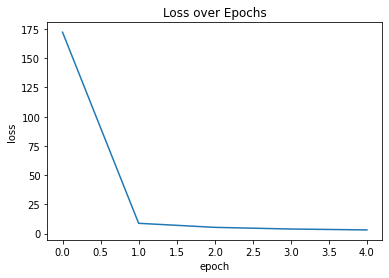

In [13]:
plt.plot(all_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss over Epochs")


In [13]:
#Testing evaluation
posteriormodel.eval()
priormodel.eval()
VAE.eval()
mseloss = torch.nn.MSELoss()
PriorL1 = []
PostL1 = []
PriorRMSE = []
PostRMSE = []
with torch.no_grad():
     for step,data in enumerate(test_loader):
        features = data['features'].squeeze(0)
        depth_patches = data['depth'].squeeze(0)
        depth_patches = center_depth(depth_patches)

        gt_depth = depth_patches.squeeze(0).permute(2,3,0,1).to(device)
        priordist = priormodel.forward(features.to(device))
        postdist = posteriormodel.forward(features.to(device),depth_patches.permute(0,3,4,1,2).to(device))
        out = VAE(features.to(device),priordist)
        out2 = VAE(features.to(device),postdist)
        PriorL1.append(float(L1loss(out,gt_depth).item()))
        PostL1.append(float(L1loss(out2,gt_depth).item()))
        PriorRMSE.append(float(mseloss(out,gt_depth).item()))
        PostRMSE.append(float(mseloss(out2,gt_depth).item()))  

In [14]:
print('Validation stats using PriorNet')
print(f'L1: {np.mean(PriorL1)} +/ {np.std(PriorL1)}')
print(f'RMSE {np.mean(np.sqrt(PriorRMSE))} +/ {np.std(np.sqrt(PriorRMSE))}')
print('Validation stats using PosteriorNet')
print(f'L1: {np.mean(PostL1)} +/ {np.std(PostL1)}')
print(f'RMSE {np.mean(np.sqrt(PostRMSE))} +/ {np.std(np.sqrt(PostRMSE))}')

Validation stats using PriorNet
L1: 0.4699551157156626 +/ 0.11244233595281754
RMSE 0.5302121828785787 +/ 0.10296935328733361
Validation stats using PosteriorNet
L1: 0.4699669110774994 +/ 0.1124561467750853
RMSE 0.5302211295669842 +/ 0.10298001676916399


In [92]:
rec = np.zeros([H,W,int(out.shape[0]*out.shape[1])])
num_overlaps = np.zeros([H,W])
itr = 0
for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        rec[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out[i,j,...].detach().cpu().numpy()
        num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
        itr = itr+1

In [93]:
rec2 = np.zeros([H,W,int(out.shape[0]*out.shape[1])])
num_overlaps = np.zeros([H,W])
itr = 0
for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        rec2[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = out2[i,j,...].detach().cpu().numpy()
        num_overlaps[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ] += 1
        itr = itr+1

In [94]:
rec_gt = np.zeros([H,W,int(out.shape[0]*out.shape[1])])
itr = 0
for i in range(out.shape[0]):
    for j in range(out.shape[1]):
        rec_gt[i*stride:i*stride + PSZ,j*stride:j*stride + PSZ,itr] = gt_depth[i,j,...].detach().cpu().numpy()
        itr = itr+1

Text(0.5, 1.0, 'Estimated Depth')

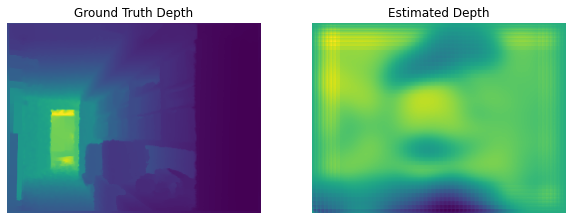

In [95]:
plt.figure(figsize=[10,20])
plt.subplot(121)
plt.imshow(np.divide(np.sum(rec_gt,axis = -1),num_overlaps))
plt.axis('off')
plt.title('Ground Truth Depth')
plt.subplot(122)
plt.imshow(np.divide(np.sum(rec,axis = -1),num_overlaps))
plt.axis('off')
plt.title('Estimated Depth')
# plt.colorbar()
# plt.figure()

# plt.colorbar()

In [99]:
nsamp = 100
manysamples = np.zeros([nsamp, H,W])

with torch.no_grad():
    for n in range(nsamp):
        manysamples[n,...] = reconstruct_img(VAE(features.to(device),priordist),H,W,stride,PSZ)

Text(0.5, 1.0, 'Variance in depth')

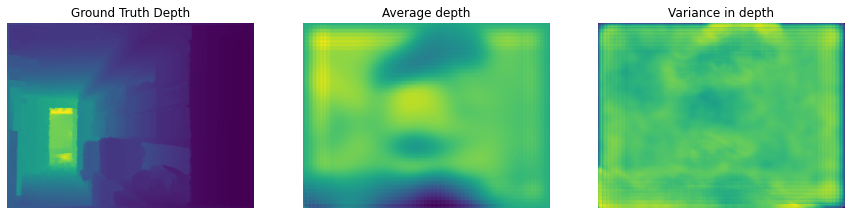

In [100]:
plt.figure(figsize=[15,45])
plt.subplot(131)
plt.imshow(np.divide(np.sum(rec_gt,axis = -1),num_overlaps))
plt.axis('off')
plt.title('Ground Truth Depth')
plt.subplot(132)
plt.imshow(np.mean(manysamples,axis=0))
plt.axis('off')
plt.title('Average depth')

plt.subplot(133)
plt.imshow(np.log(np.std(manysamples,axis=0)))
plt.axis('off')
plt.title('Variance in depth')
# plt.colorbar()